In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
import warnings
from matplotlib.patches import Rectangle
warnings.filterwarnings("ignore")

In [13]:
er_raw = pd.read_excel('ER.xlsx').drop(columns=['month','day','Date (dd:mm:yy)','Time UTC+2 (hh:mm:ss)', 
                                                                         'AC', 'LONG (E, grad dec)', 'LAT (N, grad dec)', 
                                                                         'Measured CO2 slope (ppm/s)','CO2 r^2', 
                                                                         'Meteo Stat','FM', 'Flux point', 'Flux type'])
nee_raw = pd.read_excel('NEE.xlsx').drop(columns=['month','day','Date (dd:mm:yy)','Time UTC+2 (hh:mm:ss)', 
                                                                         'AC', 'LONG (E, grad dec)', 'LAT (N, grad dec)', 
                                                                         'Measured CO2 slope (ppm/s)','CO2 r^2', 
                                                                         'Meteo Stat','FM', 'Flux point', 'Flux type'])

# Removing NaNs
er_nan = list(np.where(er_raw.isna())[0])
nee_nan = list(np.where(nee_raw.isna())[0])
tot_nan = set(er_nan+nee_nan)
er_raw2 = er_raw.drop(index=tot_nan)
nee_raw2 = nee_raw.drop(index=tot_nan)

# Removing outliers with box-and-whiskers
outliers=[]
for region, ser in er_raw2.groupby(['Site','Year','DOY']): 
    for variable in er_raw2.columns[4:]:
        q1, q3 = np.percentile(ser[variable] , [25,75])
        box = q3 - q1
        up = q3+1.5*box
        low = q1-1.5*box
        outliers.extend(ser[(ser[variable] > up) | (ser[variable] < low)].index.values)
for region, ser in nee_raw2.groupby(['Site','Year','DOY']):
    for variable in nee_raw2.columns[4:]:
        q1, q3 = np.percentile(ser[variable] , [25,75])
        box = q3 - q1
        up = q3+1.5*box
        low = q1-1.5*box
        outliers.extend(ser[(ser[variable] > up) | (ser[variable] < low)].index.values)
outliers=list(set(outliers))

# Removing data where GPP>0
er_raw3 = er_raw2.drop(index=outliers, columns='Site').reset_index(drop=True)
nee_raw3 = nee_raw2.drop(index=outliers, columns='Site').reset_index(drop=True)
GPP = nee_raw3.copy()
GPP['Corrected CO2 Flux (mol/m2/day)'] = nee_raw3['Corrected CO2 Flux (mol/m2/day)']-er_raw3['Corrected CO2 Flux (mol/m2/day)']
elim = GPP[GPP['Corrected CO2 Flux (mol/m2/day)']>0].index
df_ER = er_raw3.drop(elim).reset_index(drop=True)
df_NEE = nee_raw3.drop(elim).reset_index(drop=True)
df_GPP = GPP.drop(elim).reset_index(drop=True)
df_TOT = pd.concat([df_ER,df_NEE]).reset_index(drop=True)

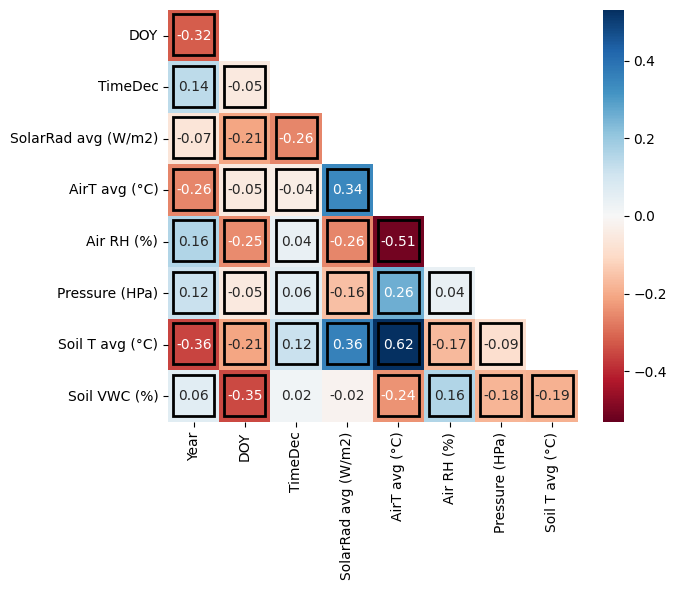

In [14]:
coef = pd.DataFrame(index=df_TOT.iloc[:,:-1].columns, columns=df_TOT.iloc[:,:-1].columns)
pval = pd.DataFrame(index=df_TOT.iloc[:,:-1].columns, columns=df_TOT.iloc[:,:-1].columns)

# Checking correlations between couples of predictors
for i in coef.columns:    
    for j in coef.columns:        
        c, p = pearsonr(df_TOT.iloc[:,:-1][i], df_TOT.iloc[:,:-1][j])  

        coef.loc[i,j] = np.round(c,2)
        
        if p<=0.05:
            pval.loc[i,j] = 1
        else:
            pval.loc[i,j] = 0

coef = coef.astype('float')
pval = pval.astype('int')
mask = np.triu(np.ones_like(coef))
fig, ax = plt.subplots(figsize=[7,6])
sns.heatmap(data=coef.iloc[1:,:-1], cmap='RdBu', annot=True, vmin=-0.53, vmax=0.53, mask=mask[1:,:-1], ax=ax)

for i in range(pval.iloc[1:,:-1].shape[0]):    
    for j in range(i+1, pval.iloc[1:,:].shape[1]): 
        if pval.iloc[i,j]==1:
            ax.add_patch(Rectangle((i+0.1,j-0.92), 0.8, 0.8, fill=False, edgecolor='black', lw=2))

plt.tight_layout()

plt.savefig('table_corr_sign.png', dpi=300)

# Ecosystem Respiration

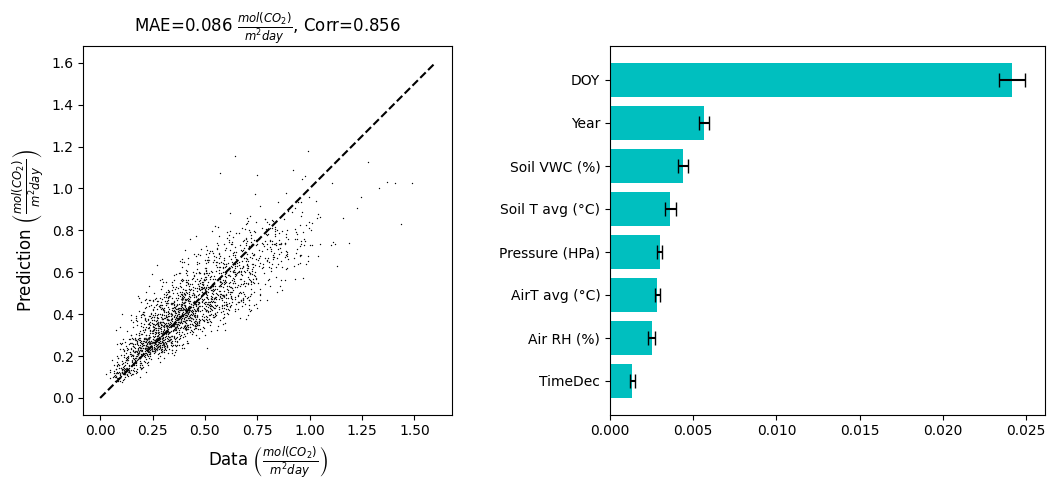

In [15]:
df = df_ER.copy()
df_X = df.drop(columns=['Corrected CO2 Flux (mol/m2/day)','SolarRad avg (W/m2)']) #  with SolarRad MAE=0.074 ExVar=0.769 Corr=0.878
df_y = df['Corrected CO2 Flux (mol/m2/day)']

data=np.array([])
pred=np.array([])
mae_tot = 0
ev_tot = 0
corr_tot = 0

results = pd.DataFrame(index=df_X.columns)
stds = pd.DataFrame(index=df_X.columns)

splits=5
kf = KFold(n_splits=splits, random_state=0, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(df_ER)):
    
    X_train, X_test = df_X.iloc[train_index], df_X.iloc[test_index]
    y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
    
    model = RandomForestRegressor(n_jobs=-1, random_state=i, bootstrap=True, criterion='squared_error', max_depth=None,
                                 max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)

    model.fit(X_train, y_train)

    y_pred=model.predict(X_test)

    regr = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=i, scoring='neg_mean_squared_error')

    mae, ev = mean_absolute_error(y_test, y_pred), explained_variance_score(y_test, y_pred)
    corr, p = pearsonr(y_test, y_pred)
    
    if p>=0.05:
        print(cycle, p)
    
    data = np.append(data, y_test)
    pred = np.append(pred, y_pred)
    mae_tot += mae/splits
    ev_tot += ev/splits
    corr_tot += corr/splits
    
    results_temp = pd.DataFrame({'parameters': model.feature_names_in_, 'importance_'+str(i): regr.importances_mean}).set_index('parameters')
    stds_temp = pd.DataFrame({'parameters': model.feature_names_in_, 'std_'+str(i): regr.importances_std}).set_index('parameters')
    
    results = results.join(results_temp)
    stds = stds.join(stds_temp)
    
results['importance_mean'] = results.mean(axis=1)
results['importance_std'] = np.sqrt((stds**2).sum(axis=1))/splits

plt.figure(figsize=[11,5])
plt.subplot(1,2,1)
sns.scatterplot(x=data, y=pred, color='k', s=1) # , alpha=0.5
plt.xlabel('Data $\\left( \\frac{mol (CO_2)}{m^2 day} \\right)$', fontsize='large')
plt.ylabel('Prediction $\\left( \\frac{mol (CO_2)}{m^2 day} \\right)$', fontsize='large')
plt.title('MAE='+str(mae_tot.round(3))+' $\\frac{mol (CO_2)}{m^2 day}$, Corr='+str(np.round(corr_tot,3)))

plt.plot([0,1.6], [0,1.6], '--k')
plt.xlim(0,1.6)
plt.ylim(0,1.6)
plt.axis('square')

plt.subplot(1,2,2)
res = results.sort_values('importance_mean', ascending=True)
plt.barh(res.index, width=res['importance_mean'], color='c', xerr=res['importance_std'], capsize=5)

plt.tight_layout()

plt.savefig('ER_everything.png', dpi=300)

# ER with different ensembles of predictors

TimeDec 1 0.4283149775318826
TimeDec 2 0.7432382781387776
TimeDec 3 0.30858444156067955
TimeDec 4 0.2530215039957261


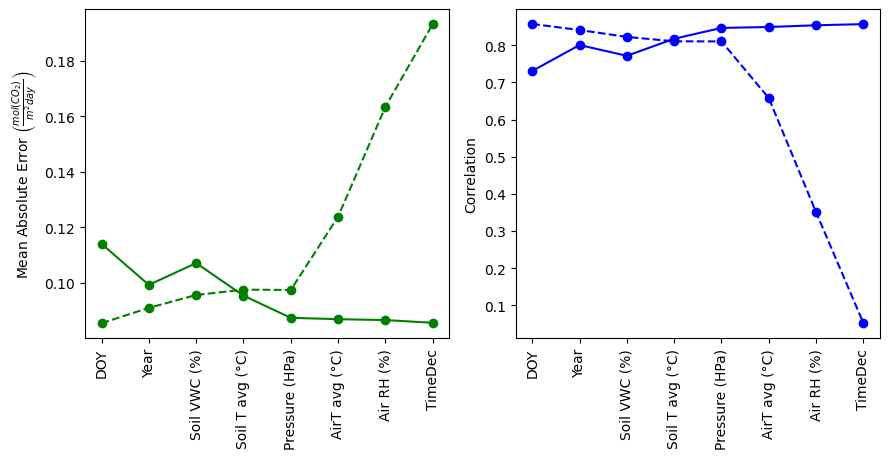

In [16]:
results = results.sort_values('importance_mean', ascending=False)

cols = []
mae_rev = []
exvar_rev = []
corr_rev = []

for col in reversed(results.index):
    cols.append(col)
    
    df_X_temp = df_X.loc[:, cols]
    df_X_temp = df_X.loc[:, cols]
    mae_temp = 0
    exvar_temp = 0
    corr_temp = 0
    
    splits=5
    kf = KFold(n_splits=splits, random_state=0, shuffle=True)

    for i, (train_index, test_index) in enumerate(kf.split(df_ER)):

        X_train, X_test = df_X_temp.iloc[train_index], df_X_temp.iloc[test_index]
        y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
    
        model = RandomForestRegressor(n_jobs=-1, random_state=0, bootstrap=True, criterion='squared_error', max_depth=None,
                                     max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)

        model.fit(X_train, y_train)

        y_pred=model.predict(X_test)

        mae, exvar = mean_absolute_error(y_test, y_pred), explained_variance_score(y_test, y_pred)
        corr, p = pearsonr(y_test, y_pred)

        if p>=0.05:
            print(col, i, p)
        mae_temp += mae/splits
        exvar_temp += exvar/splits
        corr_temp += corr/splits

    mae_rev.append(mae_temp)
    exvar_rev.append(exvar_temp)
    corr_rev.append(corr_temp)
mae_rev = mae_rev[::-1]
exvar_rev = exvar_rev[::-1]
corr_rev = corr_rev[::-1]

cols = []
mae_tot = []
exvar_tot = []
corr_tot = []

for col in results.index:
    cols.append(col)
    
    df_X_temp = df_X.loc[:, cols]
    df_X_temp = df_X.loc[:, cols]
    mae_temp = 0
    exvar_temp = 0
    corr_temp = 0
    
    splits=5
    kf = KFold(n_splits=splits, random_state=0, shuffle=True)

    for i, (train_index, test_index) in enumerate(kf.split(df_ER)):

        X_train, X_test = df_X_temp.iloc[train_index], df_X_temp.iloc[test_index]
        y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
    
        model = RandomForestRegressor(n_jobs=-1, random_state=0, bootstrap=True, criterion='squared_error', max_depth=None,
                                     max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)

        model.fit(X_train, y_train)

        y_pred=model.predict(X_test)

        mae, exvar = mean_absolute_error(y_test, y_pred), explained_variance_score(y_test, y_pred)
        corr, p = pearsonr(y_test, y_pred)

        if p>=0.05:
            print(col, i, p)
        mae_temp += mae/splits
        exvar_temp += exvar/splits
        corr_temp += corr/splits

    mae_tot.append(mae_temp)
    exvar_tot.append(exvar_temp)
    corr_tot.append(corr_temp)

fig = plt.figure(figsize=[9,4.7]) 

plt.subplot(1, 2, 1)
plt.plot(cols, mae_tot, 'o-', color='green')
plt.plot(cols, mae_rev, 'o--', color='green')
plt.ylabel('Mean Absolute Error $\\left( \\frac{mol (CO_2)}{m^2 day} \\right)$')
plt.xticks(rotation=90);

plt.subplot(1, 2, 2)
plt.plot(cols, corr_tot, 'o-', color='blue')
plt.plot(cols, corr_rev, 'o--', color='blue')
plt.ylabel('Correlation')
plt.xticks(rotation=90);

plt.tight_layout()

plt.savefig('ER_bars.png', dpi=300)

# ER with or without Year and DOY

In [17]:
df = df_ER.copy()
df_X = df.drop(columns=['Corrected CO2 Flux (mol/m2/day)','SolarRad avg (W/m2)'],axis=1)
df_y = df['Corrected CO2 Flux (mol/m2/day)']

results = pd.DataFrame(index=['All','No Year','No DOY','No DOY and Year'])

for combo in ['All','No Year','No DOY','No DOY and Year']:
    if combo=='All':
        df_X_temp = df_X.copy()
    elif combo=='No DOY':
        df_X_temp = df_X.copy().drop(columns=['DOY'])
    elif combo=='No Year':
        df_X_temp = df_X.copy().drop(columns=['Year'])
    else:
        df_X_temp = df_X.copy().drop(columns=['Year','DOY'])

    mae_tot = 0
    ev_tot = 0
    corr_tot = 0
    
    splits=5
    kf = KFold(n_splits=splits, random_state=0, shuffle=True)

    for i, (train_index, test_index) in enumerate(kf.split(df_ER)):

        X_train, X_test = df_X_temp.iloc[train_index], df_X_temp.iloc[test_index]
        y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
    

        model = RandomForestRegressor(n_jobs=-1, random_state=i, bootstrap=True, criterion='squared_error', max_depth=None,
                                     max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)

        model.fit(X_train, y_train)

        y_pred=model.predict(X_test)

        mae, ev = mean_absolute_error(y_test, y_pred), explained_variance_score(y_test, y_pred)
        corr, p = pearsonr(y_test, y_pred)
        
        if p>=0.05:
            print(cycle, p)
            
        mae_tot += mae/splits
        ev_tot += ev/splits
        corr_tot += corr/splits

    results.loc[combo, 'mae'] = mae_tot
    results.loc[combo, 'exvar'] = ev_tot
    results.loc[combo, 'corr'] = corr_tot

results.round(3)

,mae,exvar,corr
All,0.086,0.731,0.856
No Year,0.086,0.729,0.855
No DOY,0.091,0.699,0.839
No DOY and Year,0.096,0.666,0.821


# ER  without DOY, Year and TimeDec

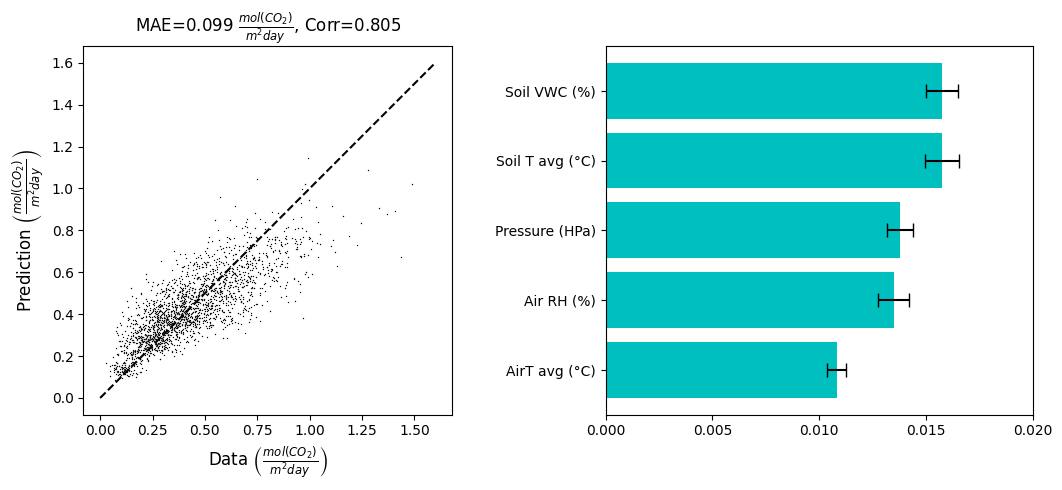

In [18]:
df = df_ER.copy()
df_X = df.drop(columns=['Corrected CO2 Flux (mol/m2/day)'],axis=1).drop(columns=['Year','DOY','TimeDec','SolarRad avg (W/m2)']) #,'SolarRad avg (W/m2)'
df_y = df['Corrected CO2 Flux (mol/m2/day)']

mae_tot = 0
ev_tot = 0
corr_tot = 0
data=np.array([])
pred=np.array([])

results = pd.DataFrame(index=df_X.columns)
stds = pd.DataFrame(index=df_X.columns)

splits=5
kf = KFold(n_splits=splits, random_state=0, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(df_ER)):
    
    X_train, X_test = df_X.iloc[train_index], df_X.iloc[test_index]
    y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]

    model = RandomForestRegressor(n_jobs=-1, random_state=i, bootstrap=True, criterion='squared_error', max_depth=None,
                                 max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)

    model.fit(X_train, y_train)

    y_pred=model.predict(X_test)

    regr = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=i, scoring='neg_mean_squared_error')

    mae, ev = mean_absolute_error(y_test, y_pred), explained_variance_score(y_test, y_pred)
    corr, p = pearsonr(y_test, y_pred)

    if p>=0.05:
        print(cycle, p)
        
    data = np.append(data, y_test)
    pred = np.append(pred, y_pred)
    mae_tot += mae/splits
    ev_tot += ev/splits
    corr_tot += corr/splits
    
    results_temp = pd.DataFrame({'parameters': model.feature_names_in_, 'importance_'+str(i): regr.importances_mean}).set_index('parameters')
    stds_temp = pd.DataFrame({'parameters': model.feature_names_in_, 'std_'+str(i): regr.importances_std}).set_index('parameters')
    
    results = results.join(results_temp)
    stds = stds.join(stds_temp)

results['importance_mean'] = results.mean(axis=1)
results['importance_std'] = np.sqrt((stds**2).sum(axis=1))/splits

plt.figure(figsize=[11,5])
plt.subplot(1,2,1)
sns.scatterplot(x=data, y=pred, color='k', s=1) 
plt.xlabel('Data $\\left( \\frac{mol (CO_2)}{m^2 day} \\right)$', fontsize='large')
plt.ylabel('Prediction $\\left( \\frac{mol (CO_2)}{m^2 day} \\right)$', fontsize='large')
plt.title('MAE='+str(mae_tot.round(3))+' $\\frac{mol (CO_2)}{m^2 day}$, Corr='+str(np.round(corr_tot,3)))

plt.plot([0,1.6], [0,1.6], '--k')
plt.xlim(0,1.6)
plt.ylim(0,1.6)
plt.axis('square')

plt.subplot(1,2,2)
res = results.sort_values('importance_mean', ascending=True)
plt.barh(res.index, width=res['importance_mean'], color='c', xerr=res['importance_std'], capsize=5)
plt.xticks(np.arange(0., 0.021, 0.005))

plt.tight_layout()

plt.savefig('ER_weather.png', dpi=300)

# Gross Primary Production

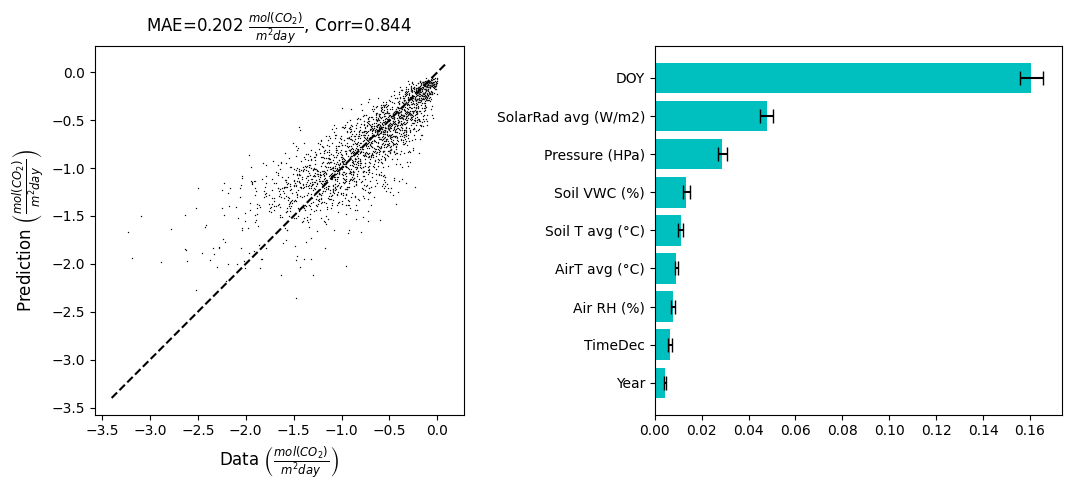

In [19]:
df = df_GPP.copy()
df_X = df.drop(columns=['Corrected CO2 Flux (mol/m2/day)'],axis=1)
df_y = df['Corrected CO2 Flux (mol/m2/day)']

data=np.array([])
pred=np.array([])
mae_tot = 0
ev_tot = 0
corr_tot = 0

results = pd.DataFrame(index=df_X.columns)
stds = pd.DataFrame(index=df_X.columns)

kf = KFold(n_splits=5, random_state=0, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(df_ER)):
    
    X_train, X_test = df_X.iloc[train_index], df_X.iloc[test_index]
    y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
    
    model = RandomForestRegressor(n_jobs=-1, random_state=i, bootstrap=True, criterion='squared_error', max_depth=None,
                                 max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)

    model.fit(X_train, y_train)

    y_pred=model.predict(X_test)

    regr = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=i, scoring='neg_mean_squared_error')

    mae, ev = mean_absolute_error(y_test, y_pred), explained_variance_score(y_test, y_pred)
    corr, p = pearsonr(y_test, y_pred)
    
    if p>=0.05:
        print(cycle, p)
    
    data = np.append(data, y_test)
    pred = np.append(pred, y_pred)
    mae_tot += mae/splits
    ev_tot += ev/splits
    corr_tot += corr/splits
    
    results_temp = pd.DataFrame({'parameters': model.feature_names_in_, 'importance_'+str(i): regr.importances_mean}).set_index('parameters')
    stds_temp = pd.DataFrame({'parameters': model.feature_names_in_, 'std_'+str(i): regr.importances_std}).set_index('parameters')
    
    results = results.join(results_temp)
    stds = stds.join(stds_temp)

results['importance_mean'] = results.mean(axis=1)
results['importance_std'] = np.sqrt((stds**2).sum(axis=1))/splits

plt.figure(figsize=[11,5])
plt.subplot(1,2,1)
sns.scatterplot(x=data, y=pred, color='k', s=1) 
plt.xlabel('Data $\\left( \\frac{mol (CO_2)}{m^2 day} \\right)$', fontsize='large')
plt.ylabel('Prediction $\\left( \\frac{mol (CO_2)}{m^2 day} \\right)$', fontsize='large')
plt.title('MAE='+str(mae_tot.round(3))+' $\\frac{mol (CO_2)}{m^2 day}$, Corr='+str(np.round(corr_tot,3)))

plt.plot([-3.4,0.1], [-3.4,0.1], '--k')
plt.xlim(-3.4,0.1)
plt.ylim(-3.4,0.1)
plt.axis('square')

plt.subplot(1,2,2)
res = results.sort_values('importance_mean', ascending=True)
plt.barh(res.index, width=res['importance_mean'], color='c', xerr=res['importance_std'], capsize=5)

plt.tight_layout()

plt.savefig('GPP_everything.png', dpi=300)

# GPP with different ensembles of predictors

Year 1 0.3645901304705769
TimeDec 0 0.277362242311224
TimeDec 1 0.19525073117477332
TimeDec 2 0.2620387644829907
TimeDec 3 0.24268662084808978
TimeDec 4 0.2961921126246063


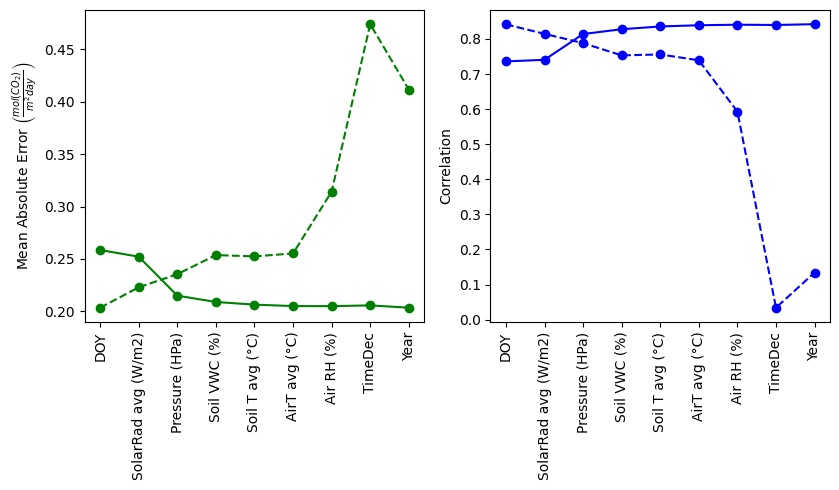

In [20]:
results = results.sort_values('importance_mean', ascending=False)

cols = []
mae_rev = []
exvar_rev = []
corr_rev = []

for col in reversed(results.index):
    cols.append(col)
    
    df_X_temp = df_X.loc[:, cols]
    df_X_temp = df_X.loc[:, cols]
    mae_temp = 0
    exvar_temp = 0
    corr_temp = 0
    
    splits=5
    kf = KFold(n_splits=splits, random_state=0, shuffle=True)

    for i, (train_index, test_index) in enumerate(kf.split(df_GPP)):

        X_train, X_test = df_X_temp.iloc[train_index], df_X_temp.iloc[test_index]
        y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
    
        model = RandomForestRegressor(n_jobs=-1, random_state=0, bootstrap=True, criterion='squared_error', max_depth=None,
                                     max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)

        model.fit(X_train, y_train)

        y_pred=model.predict(X_test)

        mae, exvar = mean_absolute_error(y_test, y_pred), explained_variance_score(y_test, y_pred)
        corr, p = pearsonr(y_test, y_pred)

        if p>=0.05:
            print(col, i, p)
        mae_temp += mae/splits
        exvar_temp += exvar/splits
        corr_temp += corr/splits

    mae_rev.append(mae_temp)
    exvar_rev.append(exvar_temp)
    corr_rev.append(corr_temp)
mae_rev = mae_rev[::-1]
exvar_rev = exvar_rev[::-1]
corr_rev = corr_rev[::-1]

cols = []
mae_tot = []
exvar_tot = []
corr_tot = []

for col in results.index:
    cols.append(col)
    
    df_X_temp = df_X.loc[:, cols]
    df_X_temp = df_X.loc[:, cols]
    mae_temp = 0
    exvar_temp = 0
    corr_temp = 0
    
    splits=5
    kf = KFold(n_splits=splits, random_state=0, shuffle=True)

    for i, (train_index, test_index) in enumerate(kf.split(df_GPP)):

        X_train, X_test = df_X_temp.iloc[train_index], df_X_temp.iloc[test_index]
        y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
    
        model = RandomForestRegressor(n_jobs=-1, random_state=0, bootstrap=True, criterion='squared_error', max_depth=None,
                                     max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)

        model.fit(X_train, y_train)

        y_pred=model.predict(X_test)

        mae, exvar = mean_absolute_error(y_test, y_pred), explained_variance_score(y_test, y_pred)
        corr, p = pearsonr(y_test, y_pred)

        if p>=0.05:
            print(i, p)
        mae_temp += mae/splits
        exvar_temp += exvar/splits
        corr_temp += corr/splits

    mae_tot.append(mae_temp)
    exvar_tot.append(exvar_temp)
    corr_tot.append(corr_temp)

fig = plt.figure(figsize=[8.5,5])

plt.subplot(1, 2, 1)
plt.plot(cols, mae_tot, 'o-', color='green')
plt.plot(cols, mae_rev, 'o--', color='green')
plt.ylabel('Mean Absolute Error $\\left( \\frac{mol (CO_2)}{m^2 day} \\right)$')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.plot(cols, corr_tot, 'o-', color='blue')
plt.plot(cols, corr_rev, 'o--', color='blue')
plt.ylabel('Correlation')
plt.xticks(rotation=90)

plt.tight_layout()

plt.savefig('GPP_bars.png', dpi=300)

# GPP with or without Year and DOY

In [21]:
df = df_GPP.copy()
df_X = df.drop(columns=['Corrected CO2 Flux (mol/m2/day)'],axis=1)
df_y = df['Corrected CO2 Flux (mol/m2/day)']

results = pd.DataFrame(index=['All','No Year','No DOY','No DOY and Year'])

for combo in ['All','No Year','No DOY','No DOY and Year']:
    if combo=='All':
        df_X_temp = df_X.copy()
    elif combo=='No DOY':
        df_X_temp = df_X.copy().drop(columns=['DOY'])
    elif combo=='No Year':
        df_X_temp = df_X.copy().drop(columns=['Year'])
    else:
        df_X_temp = df_X.copy().drop(columns=['Year','DOY'])

    mae_tot = 0
    ev_tot = 0
    corr_tot = 0
    
    splits=5
    kf = KFold(n_splits=splits, random_state=0, shuffle=True)

    for i, (train_index, test_index) in enumerate(kf.split(df_ER)):

        X_train, X_test = df_X_temp.iloc[train_index], df_X_temp.iloc[test_index]
        y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
    

        model = RandomForestRegressor(n_jobs=-1, random_state=i, bootstrap=True, criterion='squared_error', max_depth=None,
                                     max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)

        model.fit(X_train, y_train)

        y_pred=model.predict(X_test)

        mae, ev = mean_absolute_error(y_test, y_pred), explained_variance_score(y_test, y_pred)
        corr, p = pearsonr(y_test, y_pred)
        
        if p>=0.05:
            print(cycle, p)
            
        mae_tot += mae/splits
        ev_tot += ev/splits
        corr_tot += corr/splits

    results.loc[combo, 'mae'] = mae_tot
    results.loc[combo, 'exvar'] = ev_tot
    results.loc[combo, 'corr'] = corr_tot

results.round(3)

,mae,exvar,corr
All,0.202,0.710,0.844
No Year,0.205,0.705,0.841
No DOY,0.223,0.655,0.814
No DOY and Year,0.227,0.642,0.806


# GPP without DOY, Year and TimeDec

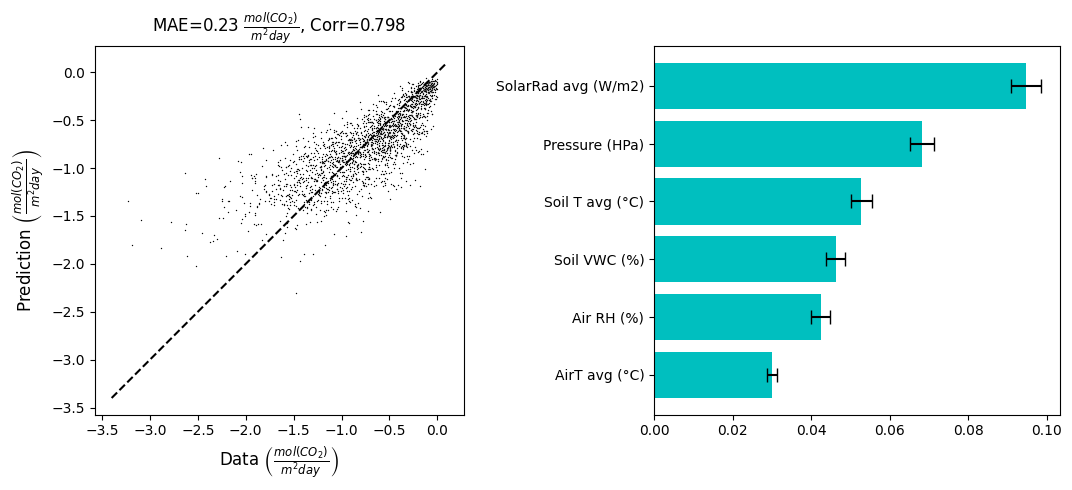

In [22]:
df = df_GPP.copy()
df_X = df.drop(columns=['Corrected CO2 Flux (mol/m2/day)'],axis=1).drop(columns=['Year','DOY','TimeDec'])
df_y = df['Corrected CO2 Flux (mol/m2/day)']

mae_tot = 0
ev_tot = 0
corr_tot = 0
data=np.array([])
pred=np.array([])

results = pd.DataFrame(index=df_X.columns)
stds = pd.DataFrame(index=df_X.columns)

splits=5
kf = KFold(n_splits=splits, random_state=0, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(df_ER)):
    
    X_train, X_test = df_X.iloc[train_index], df_X.iloc[test_index]
    y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]

    model = RandomForestRegressor(n_jobs=-1, random_state=i, bootstrap=True, criterion='squared_error', max_depth=None,
                                 max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)

    model.fit(X_train, y_train)

    y_pred=model.predict(X_test)

    regr = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=i, scoring='neg_mean_squared_error')

    mae, ev = mean_absolute_error(y_test, y_pred), explained_variance_score(y_test, y_pred)
    corr, p = pearsonr(y_test, y_pred)

    if p>=0.05:
        print(cycle, p)
        
    data = np.append(data, y_test)
    pred = np.append(pred, y_pred)
    mae_tot += mae/splits
    ev_tot += ev/splits
    corr_tot += corr/splits
    
    results_temp = pd.DataFrame({'parameters': model.feature_names_in_, 'importance_'+str(i): regr.importances_mean}).set_index('parameters')
    stds_temp = pd.DataFrame({'parameters': model.feature_names_in_, 'std_'+str(i): regr.importances_std}).set_index('parameters')

    results = results.join(results_temp)
    stds = stds.join(stds_temp)

results['importance_mean'] = results.mean(axis=1)
results['importance_std'] = np.sqrt((stds**2).sum(axis=1))/splits

plt.figure(figsize=[11,5])
plt.subplot(1,2,1)
sns.scatterplot(x=data, y=pred, color='k', s=1)
plt.xlabel('Data $\\left( \\frac{mol (CO_2)}{m^2 day} \\right)$', fontsize='large')
plt.ylabel('Prediction $\\left( \\frac{mol (CO_2)}{m^2 day} \\right)$', fontsize='large')
plt.title('MAE='+str(mae_tot.round(3))+' $\\frac{mol (CO_2)}{m^2 day}$, Corr='+str(np.round(corr_tot,3)))

plt.plot([-3.4,0.1], [-3.4,0.1], '--k')
plt.xlim(-3.4,0.1)
plt.ylim(-3.4,0.1)
plt.axis('square')

plt.subplot(1,2,2)
res = results.sort_values('importance_mean', ascending=True)
plt.barh(res.index, width=res['importance_mean'], color='c', xerr=res['importance_std'], capsize=5)

plt.tight_layout()

plt.savefig('GPP_weather.png', dpi=300)